# Comparison of scaled and unscaled robustness curves for l_2 and l_inf norms

In [ ]:
import os
os.chdir("../")
import sys
import copy
import json
from argparse import Namespace
import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances as dist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

import provable_robustness_max_linear_regions.data as dt
from generate_robustness_curves import generate_curve_data
from utils import NumpyEncoder

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate robustness curves:
Estimated runtime (if no file with data is present): 8 days

In [3]:
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            loaded_json =  json.load(fp)

            for key in loaded_json.keys():
                loaded_json[key]["x"] = np.array(loaded_json[key]["x"])
                loaded_json[key]["y"] = np.array(loaded_json[key]["y"])

                loaded_json[key]["y"][np.isnan(loaded_json[key]["x"])] = 1.0
                loaded_json[key]["x"] = np.nan_to_num(loaded_json[key]["x"], nan = np.nanmax(loaded_json[key]["x"]))

            return loaded_json
        
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)


training_method_to_model_path = {"ST": "provable_robustness_max_linear_regions/models/plain/2019-02-24 00:50:45 dataset=mnist nn_type=cnn_lenet_small p_norm=2 lmbd=0.0 gamma_rb=0.0 gamma_db=0.0 ae_frac=0.0 lr=0.001 epoch=100.mat",
                                 "MMR+AT_l_inf": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 01:54:16 dataset=mnist nn_type=cnn_lenet_small p_norm=inf lmbd=0.5 gamma_rb=0.2 gamma_db=0.2 ae_frac=0.5 epoch=100.mat", 
                                 "MMR+AT_l_2": "provable_robustness_max_linear_regions/models/mmr+at/2019-02-24 00:04:27 dataset=mnist nn_type=cnn_lenet_small p_norm=2 lmbd=6.0 gamma_rb=0.45 gamma_db=0.45 ae_frac=0.5 lr=5e-05 epoch=50.mat", 
                                 "KW_l_inf": "provable_robustness_max_linear_regions/models/kw/p_norm=inf dataset=mnist_model=cnn_lenet_small_method=robust_eps=0.1_checkpoint.mat", 
                                 "KW_l_2": "provable_robustness_max_linear_regions/models/kw/p_norm=2 dataset=mnist_model=cnn_lenet_small_method=robust_eps=0.3_checkpoint.mat", 
                                 "AT_l_inf": "provable_robustness_max_linear_regions/models/at/2019-02-19 01:20:16 dataset=mnist nn_type=cnn_lenet_small p_norm=inf lmbd=0.0 gamma_rb=0.0 gamma_db=0.0 ae_frac=0.5 epoch=100.mat", 
                                 "AT_l_2": "provable_robustness_max_linear_regions/models/at/2019-02-24 00:50:45 dataset=mnist nn_type=cnn_lenet_small p_norm=2 lmbd=0.0 gamma_rb=0.0 gamma_db=0.0 ae_frac=0.5 lr=0.001 epoch=100.mat"}

n_points = 10000

robustness_curve_data = dict()

for training_method in ["ST", "MMR+AT_l_inf", "MMR+AT_l_2"]:
    
    robustness_curve_data[training_method] = load_from_json("rob_curve_data_{}_n_points={}".format(training_method, n_points))
                                           
    if not robustness_curve_data[training_method]:

        args = Namespace()

        args.dataset = "mnist"
        args.n_points = n_points
        args.model_path = training_method_to_model_path[training_method]
        args.nn_type = "cnn"
        args.norms = ["inf", "2"]
        args.save = False
        args.plot = False

        robustness_curve_data[training_method] = generate_curve_data(args)

        save_to_json(robustness_curve_data[training_method], "rob_curve_data_{}_n_points={}".format(training_method, n_points))     

## Plot:

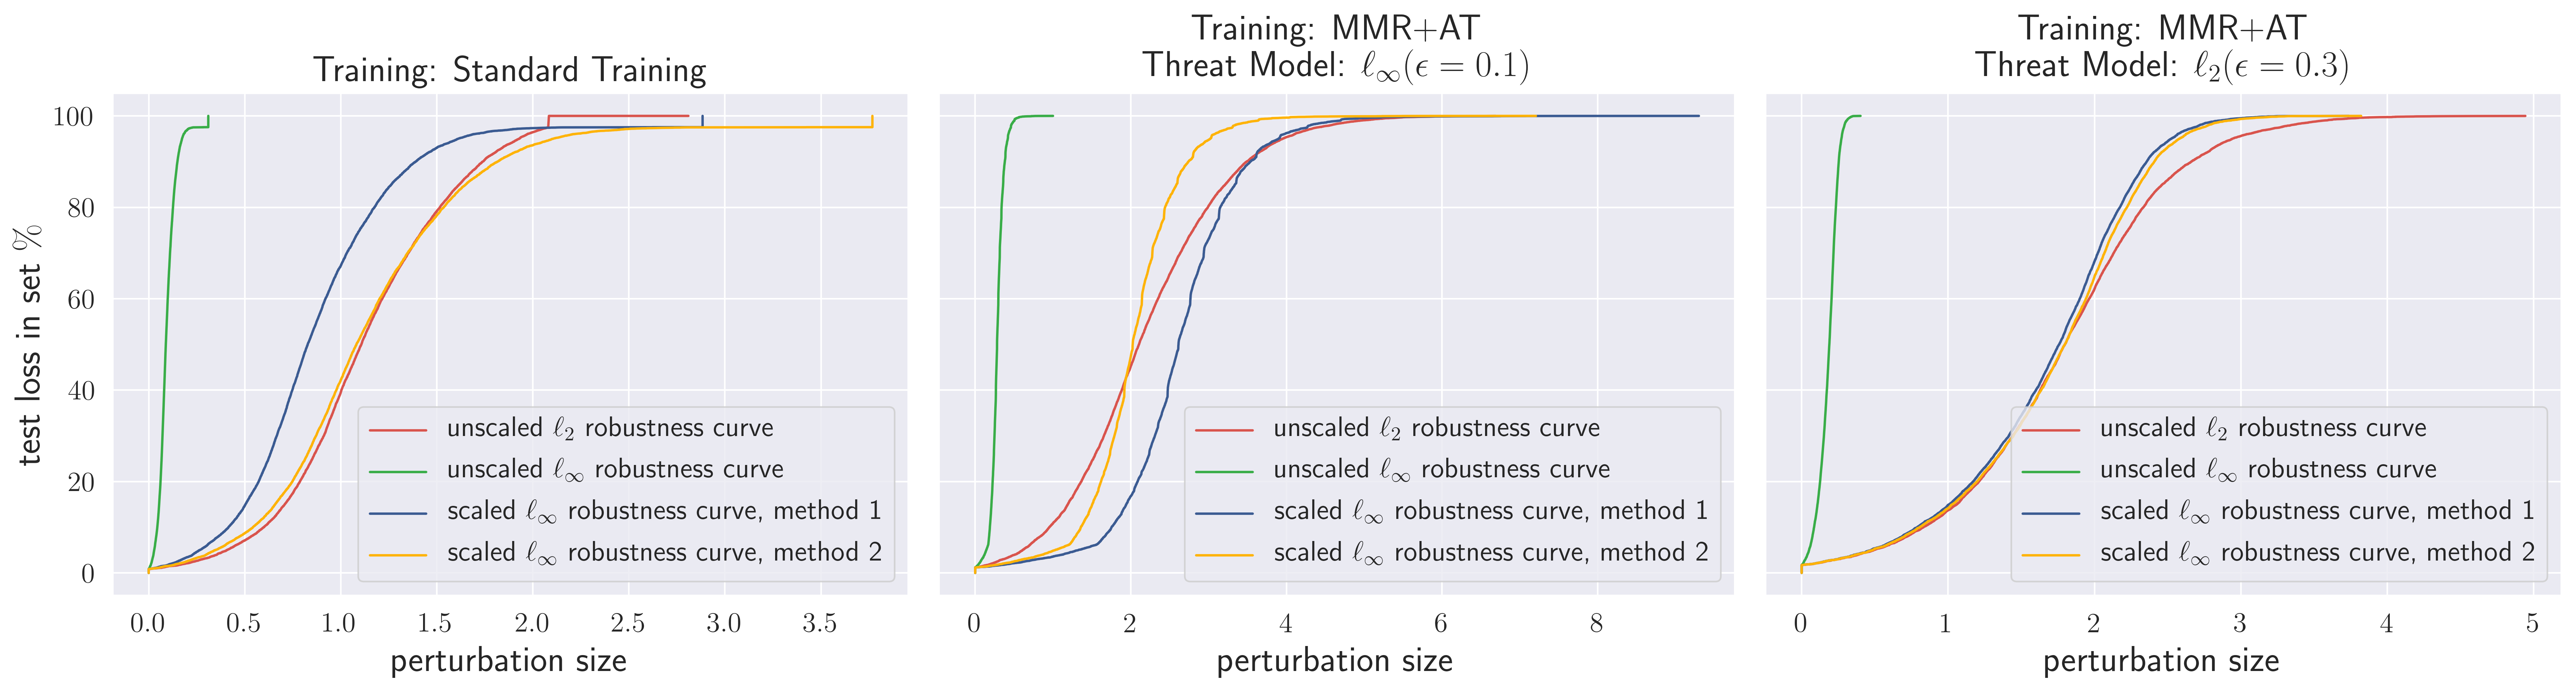

In [4]:
def scale_data_1(data, norms, norm_to_scale_to):

    norm_to_ord = {"2": 2, "1":1, "inf": np.Inf}
    data = copy.deepcopy(data)

    _, x_test, _, _ = dt.get_dataset("mnist")
    n_points = x_test.shape[0]

    x_test = x_test.reshape(n_points, 784)

    for norm in norms:

        scaling_factor = 0
        for point in x_test:
            scaling_factor += np.sum(np.divide(np.linalg.norm(point, ord = norm_to_ord[norm_to_scale_to]), np.linalg.norm(point, ord = norm_to_ord[norm]), out = np.zeros_like(np.linalg.norm(point, ord = norm_to_ord[norm_to_scale_to])), where = np.linalg.norm(point, ord = norm_to_ord[norm]) !=0))

        scaling_factor *= (1/n_points)

        data[norm]["x"]*= scaling_factor

    return data

def scale_data_2(data, norms, norm_to_scale_to):

    data = copy.deepcopy(data)

    for norm in norms:
        data[norm]["x"]*= ((1/data[norm]["x"].shape[0]) * np.sum(np.divide(data[norm_to_scale_to]["x"], data[norm]["x"], out = np.zeros_like(data[norm_to_scale_to]["x"]), where = data[norm]["x"] !=0)))

    return data

# name to save the plot
save_name = "fig_rc_scaled_unscaled_2"

training_method_to_col_title = {"ST": "Training: Standard Training",
                             "MMR+AT_l_inf": "Training: MMR+AT\nThreat Model: $\ell_\infty(\epsilon=0.1)$", 
                             "MMR+AT_l_2": "Training: MMR+AT\nThreat Model: $\ell_2(\epsilon=0.3)$", 
                             "KW_l_inf": "Training: KW\nThreat Model: $\ell_\infty(\epsilon=0.1)$", 
                             "KW_l_2": "Training: KW\nThreat Model: $\ell_2(\epsilon=0.3)$", 
                             "AT_l_inf": "Training: AT\nThreat Model: $\ell_\infty(\epsilon=0.1)$", 
                             "AT_l_2": "Training: AT\nThreat Model: $\ell_2(\epsilon=0.3)$"}

# number of model types and parameter combinations
n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize = (6 * n_cols, 5 * n_rows), sharey = 'row', sharex = "col", dpi=400)

for i, training_method in enumerate(["ST", "MMR+AT_l_inf", "MMR+AT_l_2"]):
    robustness_curve_data_scaled_1 = scale_data_1(robustness_curve_data[training_method], ["2", "inf"], "2")
    robustness_curve_data_scaled_2 = scale_data_2(robustness_curve_data[training_method], ["2", "inf"], "2")

    ax[i].plot(robustness_curve_data[training_method]["2"]["x"], robustness_curve_data[training_method]["inf"]["y"] * 100, c = colors["red"], label = "unscaled $\ell_{2}$ robustness curve")
    ax[i].plot(robustness_curve_data[training_method]["inf"]["x"], robustness_curve_data[training_method]["inf"]["y"] * 100, c = colors["green"], label = "unscaled $\ell_{\infty}$ robustness curve")
    ax[i].plot(robustness_curve_data_scaled_1["inf"]["x"], robustness_curve_data[training_method]["inf"]["y"] * 100, c = colors["blue"], label = "scaled $\ell_{\infty}$ robustness curve, method 1")
    ax[i].plot(robustness_curve_data_scaled_2["inf"]["x"], robustness_curve_data[training_method]["inf"]["y"] * 100, c = colors["yellow"], label = "scaled $\ell_{\infty}$ robustness curve, method 2")

    ax[i].legend()
    ax[i].set_xlabel("perturbation size")
    ax[i].set_title("{}".format(training_method_to_col_title[training_method]))

ax[0].set_ylabel("test loss in set $\%$")

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))